In [11]:
#set how we want to run the notebook this time

do_sysrem = True
do_cross_correlate = True
do_inject_model = False
do_combine = False
do_molecfit = True
import time

initial_time=time.time()

arm = 'red'

#SYSREM parameters
niter = 10 #use: 2/3 for red 0501/0518, 3/3 for blue

if do_inject_model:
    model_tag = 'injected'
else:
    model_tag = ''
    
planet_name = 'WASP-189b'
species_label = 'Fe I'
temperature_profile = 'two-point' #'inverted-emission'
vmr = 5.4e-5
observation_epoch = '20230327' #'20211031' #'20210501' #'
new_date = ['20230327'] #['20210501','20210501','20210518']
new_arm = ['blue'] #['red','blue','blue']
scale_factor = 1.



In [2]:
#put all of the species selection here so I don't have to change it out manually anymore
if species_label == 'TiO':
    species_name_inject = 'TiO_48_Exomol_McKemmish'#'TiO_all_iso_Plez'
    species_name_ccf = 'TiO_48_Exomol_McKemmish'

    
if species_label == 'VO':
    species_name_inject = 'VO'
    species_name_ccf = 'VO_ExoMol_McKemmish'
    
if species_label == 'FeH':
    species_name_inject = 'FeH_main_iso'
    species_name_ccf = 'FeH_main_iso'
    
if species_label == 'Fe I':
    species_name_inject = 'Fe'
    species_name_ccf = 'Fe'
    
if species_label == 'Fe II':
    species_name_inject = 'Fe+'
    species_name_ccf = 'Fe+'
    
if species_label == 'Cr I':
    species_name_inject = 'Cr'
    species_name_ccf = 'Cr'
    
if species_label == 'Si I':
    species_name_inject = 'Si'
    species_name_ccf = 'Si'

if species_label == 'SiO':
    species_name_inject = 'SiO_main_iso_new_incl_UV'
    species_name_ccf = 'SiO_main_iso_new_incl_UV'
    
if species_label == 'H2O':
    species_name_inject = 'H2O_main_iso'
    species_name_ccf = 'H2O_main_iso'
    
if species_label == 'OH':
    species_name_inject = 'OH_main_iso'
    species_name_ccf = 'OH_main_iso'
    
#Do the same auto-selection with the SYSREM parameters
if arm == 'blue': 
    do_molecfit = False #we never do Molecfit for the blue arm
    n_systematics = [3, 3]
elif observation_epoch == '20210501':
    n_systematics = [1, 2]
elif observation_epoch == '20210518':
    n_systematics = [1, 3]
else:
    n_systematics = [1, 3]

In [3]:
#import packages
import numpy as np
import matplotlib.pyplot as pl
from glob import glob
from astropy.io import fits

from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u
from astropy.table import Table

from uncertainties import ufloat
from uncertainties import unumpy as unp

from atmo_utilities import ccf

n_systematics = np.array(n_systematics)

In [4]:
#define some constants

MJoMS = 1./1047. #MJ in MSun

if planet_name == 'KELT-20b':
    #For KELT-20 b:, from Lund et al. 2018
    Period = ufloat(3.4741085, 0.0000019) #days
    epoch = ufloat(2457503.120049, 0.000190) #BJD_TDB

    M_star = ufloat(1.76, 0.19) #MSun
    RV_abs = ufloat(0.0, 0.0) #km/s
    i = ufloat(86.12, 0.28) #degrees
    M_p = 3.382 #3-sigma limit

    RA = '19h38m38.74s'
    Dec = '+31d13m09.12s'
    
    dur = 3.755/24. #hours -> days
    
if planet_name == 'WASP-76b':
    #For WASP-76 b:, from West et al. 2016
    Period = ufloat(1.809886, 0.000001) #days
    epoch = ufloat(2456107.85507, 0.00034) #BJD_TDB

    M_star = ufloat(1.46, 0.07) #MSun
    RV_abs = ufloat(-1.152, 0.0033) #km/s
    i = ufloat(88.0, 1.6) #degrees
    M_p = 0.92

    RA = '01h46m31.90s'
    Dec = '+02d42m01.40s'
    
    dur = 3.694/24.
    
if planet_name == 'KELT-9b':
    #For KELT-9 b:, from Gaudi et al. 2017 and Pai Asnodkar et al. 2021
    Period = ufloat(1.4811235, 0.0000011) #days
    epoch = ufloat(2457095.68572, 0.00014) #BJD_TDB

    M_star = ufloat(2.11, 0.78) #MSun
    RV_abs = ufloat(0.0, 1.0) #km/s
    i = ufloat(86.79, 0.25) #degrees
    M_p = ufloat(2.17, 0.56)

    RA = '20h31m26.38s'
    Dec = '+39d56m20.10s'
    
if planet_name == 'WASP-189b':
    #For WASP-18b: from Cortes-Zuleta+20
    Period = ufloat(2.7240308, 0.0000028) #days
    epoch = ufloat(2458926.5416960, 0.0000650) #BJD_TDB

    M_star = ufloat(2.030, 0.066) #MSun
    RV_abs = ufloat(0.0, 0.0) #km/s
    i = ufloat(84.03, 0.14) #degrees
    M_p = ufloat(1.99, 0.16)
    R_p = 1.619

    RA = '15h02m44.82s'
    Dec = '-03d01m53.35s'

    dur = 4.3336/24.


Kp_expected = 28.4329 * M_star/MJoMS * unp.sin(i*np.pi/180.) * (M_star + M_p * MJoMS) ** (-2./3.) * (Period/365.25) ** (-1./3.) / 1000. #to km/s
ckms = 2.9979e5

In [5]:
print(Kp_expected)

191.8+/-2.1


In [6]:
#get data
if arm == 'blue':
    arm_file = 'pepsib'
if arm == 'red':
    arm_file = 'pepsir'
    
    
#change 'avr' to 'nor' below for more recent data
if not do_molecfit:
    data_location = 'data/' + observation_epoch + '_' + planet_name + '/' + arm_file + '*.dxt.nor'
else:
    data_location = 'data/' + observation_epoch + '_' + planet_name + '/molecfit_weak/SCIENCE_TELLURIC_CORR_' + arm_file + '*.dxt.nor.fits'
spectra_files = glob(data_location)

n_spectra = len(spectra_files)
i=0
jd, snr_spectra, exptime = np.zeros(n_spectra), np.zeros(n_spectra), np.zeros(n_spectra,dtype=str)
airmass = np.zeros(n_spectra)

for spectrum in spectra_files:
    hdu = fits.open(spectrum)
    data, header = hdu[1].data, hdu[0].header
    if do_molecfit: wave_tag, flux_tag = 'lambda', 'flux'
    if not do_molecfit: wave_tag, flux_tag = 'Arg', 'Fun'
    if i ==0:
        npix = len(data[wave_tag])
        wave, fluxin, errorin = np.zeros((n_spectra, npix)), np.zeros((n_spectra, npix)), np.zeros((n_spectra, npix))
    #have to do the following because for some reason some datasets do not have consistent numbers of pixels
    wave[i,:]=data[wave_tag][0:npix]
    fluxin[i,:]=data[flux_tag][0:npix]
    if not do_molecfit:
        errorin[i,:]=np.sqrt(data['Var'][0:npix])
    else:
        wave[i,:]*=10000. #microns -> Angstroms
        errorin[i,:]=np.sqrt(data['error'][0:npix])
        
        #remove shift introduced to make Molecfit work
        if observation_epoch == '20210501': introduced_shift = 6000.
        if observation_epoch == '20210518': introduced_shift = 3500.
        if observation_epoch == '20190425': introduced_shift = 464500.
        if observation_epoch == '20190504': introduced_shift = 6300.
        if observation_epoch == '20190515': introduced_shift = 506000.
        if observation_epoch == '20190623': introduced_shift = -334000.
        if observation_epoch == '20190625': introduced_shift = 97800.
        if observation_epoch == '20211031': introduced_shift = -94200.
        if observation_epoch == '20230327': introduced_shift = -23900.
        try:
            doppler_shift = 1.0 / (1.0 - (hdu[0].header['RADVEL'] + hdu[0].header['OBSVEL'] + introduced_shift) / 1000. / ckms)
        except:
            doppler_shift = 1.0 / (1.0 - (hdu[0].header['RADVEL'] + hdu[0].header['SSBVEL'] + introduced_shift) / 1000. / ckms)
        wave[i,:] *= doppler_shift
        
    
    jd[i] = header['JD-OBS'] #mid-exposure time
    snr_spectra[i] = header['SNR']
    exptime[i] = header['EXPTIME'] #in decimal h/m/s. WHYYYYYY
    airmass[i] = header['AIRMASS']
    
            
    #pl.plot(wave[i,:], fluxin[i,:]/errorin[i,:])
    
    hdu.close()
    i+=1
    
#glob gets the files out of order for some reason so we have to put them in time order
obs_order = np.argsort(jd)

jd, snr_spectra, exptime, airmass = jd[obs_order], snr_spectra[obs_order], exptime[obs_order], airmass[obs_order]

wave, fluxin, errorin = wave[obs_order,:], fluxin[obs_order,:], errorin[obs_order,:]

pl.figure(figsize=(7, 2.5))
pl.plot(wave[0,:], fluxin[0,:], color='black')
pl.xlabel('wavelength (Angstroms)')
pl.ylabel('normalized flux')

pl.xlim(np.min(wave[0,:]), np.max(wave[0,:]))

pl.tight_layout()

pl.savefig('plots/final/red_spectrum_20210501.pdf',format='pdf')
pl.clf()

<Figure size 504x180 with 0 Axes>

In [7]:
i=0
hdu = fits.open(spectra_files[i])
data, header = hdu[1].data, hdu[0].header
print(hdu[0].header['RADVEL'])
                

-22400.0


In [8]:
#convert JDs to BJDs

lbt_coordinates = EarthLocation.of_site('lbt')

observed_times = Time(jd, format='jd', location=lbt_coordinates)

coordinates = SkyCoord(RA+' '+Dec, frame='icrs', unit=(u.hourangle, u.deg))

ltt_bary = observed_times.light_travel_time(coordinates)

bary_times = observed_times + ltt_bary

orbital_phase = (bary_times.value - epoch)/Period
orbital_phase -= np.round(np.mean(unp.nominal_values(orbital_phase)))

#if transmission, restrict to in-transit data
half_duration_phase = (dur/2.)/Period.n
in_transit_spectra = np.abs(unp.nominal_values(orbital_phase)) <= half_duration_phase

In [9]:
print(np.min(airmass), np.max(airmass))
print(np.min(orbital_phase), np.max(orbital_phase))
print(n_spectra)
print(np.mean(snr_spectra))

1.2334 1.8809
0.3731+/-0.0004 0.4444+/-0.0004
69
465.5507246376812


In [12]:
#Load atmospheric model
filein = 'templates/' + planet_name + '.' + species_name_ccf + '.' + str(vmr) + '.' + temperature_profile + '.combined.fits'
hdu = fits.open(filein)

template_wave = hdu[1].data['wave']
template_flux = hdu[1].data['flux']

hdu.close()

if do_inject_model:
    if species_name_ccf != species_name_inject:
        filein = 'templates/' + planet_name + '.' + species_name_inject + '.' + str(vmr) + '.' + temperature_profile + '.combined.fits'
        hdu = fits.open(filein)

        template_wave_in = hdu[1].data['wave']
        template_flux_in = hdu[1].data['flux']

        hdu.close()
    else:
        template_wave_in = template_wave
        template_flux_in = template_flux

In [13]:
#inject model into data
if do_inject_model:
    Kp_true, V_sys_true = unp.nominal_values(Kp_expected), 0.0
    
    
    RV = Kp_true*np.sin(2.*np.pi*unp.nominal_values(orbital_phase)) + V_sys_true
    
    for i in range (n_spectra):
        if not 'transmission' in temperature_profile or np.abs(orbital_phase[i].n) <= half_duration_phase:
            doppler_shift = 1.0 / (1.0 - RV[i] / ckms)
            planet_flux = np.interp(wave[i,:], template_wave_in * doppler_shift, template_flux_in)
            if scale_factor != 1.0:
                planet_flux *=  scale_factor
            
            fluxin[i,:] += planet_flux   

In [14]:
#Will probably want to measure the telluric velocities to correct for any velocity drift here

In [15]:
#Regrid to common wavelength scale

#For now, just choose the wavelength scale of the first spectrum
for i in range (1, n_spectra):
    tempflux = np.interp(wave[0,:], wave[i,:], fluxin[i,:])
    temperror = np.interp(wave[0,:], wave[i,:], errorin[i,:])
    fluxin[i,:], errorin[i,:] = tempflux, temperror
    
wave=wave[i,:]
#can't do the proper error propagation until we regrid
flux = unp.uarray(fluxin, errorin)

The maximum total SNR is  811.6147965138571


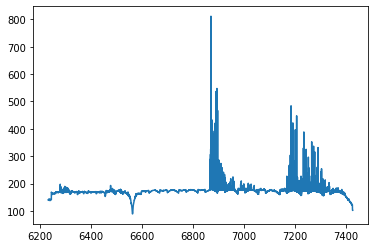

In [16]:
#Create stacked spectrum and remove from time series spectra
median_flux1, median_error = np.zeros(npix), np.zeros(npix)
residual_flux = unp.uarray(np.zeros((n_spectra, npix)), np.zeros((n_spectra, npix)))
total_flux, total_error = np.zeros(npix), np.zeros(npix)

for i in range (0, npix):
    median_flux1[i] = np.median(unp.nominal_values(flux[:,i]))
    #median doesn't really propagate errors correctly, so we need to do it by hand
    little_n = (n_spectra-1)/2
    #The latter estimated median error comes from https://mathworld.wolfram.com/StatisticalMedian.html
    median_error[i] = np.sqrt(np.sum(unp.std_devs(flux[:,i])**2))/n_spectra/np.sqrt(4*little_n/(np.pi*n_spectra))
    total_flux[i] = np.sum(unp.nominal_values(flux[:,i]))
    total_error[i] = np.sqrt(np.sum(unp.std_devs(flux[:,i])**2))
    
median_flux = unp.uarray(median_flux1, median_error)
    
for i in range (0, n_spectra):
    residual_flux[i,:] = flux[i, :] - median_flux

total_snr = total_flux/total_error
pl.plot(wave, total_snr)
print('The maximum total SNR is ', np.max(total_snr))

In [17]:
#Regrid template spectrum for use in weighting combined CCFs
regridded_template_flux = np.interp(wave, template_wave, template_flux)
ccf_weights = snr_spectra * np.sum(regridded_template_flux)

In [18]:
#Make some diagnostic plots
from dtutils import psarr

#good = (wave > 4800) & (wave < 5400.)

plotname = 'plots/' + planet_name + '.' + observation_epoch + '.' + arm + '.spectrum-resids.pdf'

psarr(unp.nominal_values(residual_flux), wave, unp.nominal_values(orbital_phase), 'wavelength (Angstroms)', 'orbital phase', 'flux residual', filename=plotname,flat=True, ctable='gist_gray')

<Figure size 504x180 with 0 Axes>

In [ ]:
#Implement SYSREM
#The code below is adapted from PySysRem, by Stephanie T. Douglas
#https://github.com/stephtdouglas/PySysRem/blob/master/sysrem.py

if do_sysrem:
    
    
    start_time = time.time()

    #Running SYSREM with the uncertainties is just too slow, so unfortunately we have to go 
    #back to manual tracking
    corrected_flux = unp.nominal_values(residual_flux)
    corrected_error = unp.std_devs(residual_flux)
    
    if arm == 'red':
        no_tellurics = np.where((wave <= 6277.) | ((wave > 6328.) & (wave <= 6459.)) | ((wave > 6527.) & (wave <= 6867.)))
        has_tellurics = np.where(((wave > 6277.) & (wave <= 6328.)) | ((wave > 6459.) & (wave <= 6527.)) | ((wave > 6867.) & (wave < 6867.5)) | ((wave >= 6930.) & (wave < 7168.)) | (wave >= 7312.))
        has_tellurics, no_tellurics = has_tellurics[0], no_tellurics[0]
        if do_molecfit:
            do_mask = np.where(((wave >= 6867.5) & (wave < 6930.)) | ((wave >= 7168.) & (wave < 7312.)))
            do_mask = do_mask[0]
            corrected_flux[:,do_mask] = 0.0
            corrected_error[:,do_mask] = 1.0
        #else:
            
        chunks = 2
    else:
        no_tellurics = np.where((wave > 3000.) & (wave < 7000.))
        no_tellurics = no_tellurics[0]
        chunks = 1
    
    print('starting now ',time.time()-start_time)
    
    for chunk in range (chunks):
        if chunk == 0: this_one = no_tellurics
        if chunk == 1: this_one = has_tellurics
        npixhere = len(this_one)
        for system in range (n_systematics[chunk]):
            print('Removing systematic number ',system+1,' for chunk ',chunk+1)
    
            c, sigma_c, sigma_a = np.zeros(npixhere), np.zeros(npixhere), np.zeros(n_spectra)
            if system == 0:
                a = np.array(airmass)
            else:
                a = np.ones(n_spectra)
            
            for iter in range (niter):
            
                #minimize c for each pixel
                for s in range (npixhere):
                    err_squared = (corrected_error[:,this_one[s]])**2
                    numerator = np.sum(a*corrected_flux[:,this_one[s]]/err_squared)
                    saoa = sigma_a/a
                    bad = ~np.isfinite(saoa)
                    saoa[bad] = 0.0
                    eof = corrected_error[:,this_one[s]]/corrected_flux[:,this_one[s]]
                    bad = ~np.isfinite(eof)
                    eof[bad] = 0.0
                    sigma_1 = np.abs(a*corrected_flux[:,this_one[s]]/err_squared) * np.sqrt(saoa**2+eof**2)
                    sigma_numerator = np.sqrt(np.sum(sigma_1**2))
                    denominator = np.sum(a**2/err_squared)
                    sigma_2 = np.sqrt(2.)*np.abs(a)*sigma_a/err_squared
                    sigma_denominator = np.sqrt(np.sum(sigma_2**2))
                    c[s] = numerator/denominator
                    sigma_c[s] = np.abs(c[s]) * np.sqrt((sigma_numerator/numerator)**2+(sigma_denominator/denominator)**2)
                    #if ~np.isfinite(c[s]) or ~np.isfinite(sigma_c[s]): print('c',chunk,system,iter,s,c[s],sigma_c[s])
                #using c, minimize a for each epoch
                for ep in range (n_spectra):
                    err_squared = (corrected_error[ep,this_one])**2
                    numerator = np.sum(c*corrected_flux[ep,this_one]/err_squared) 
                    scoc = sigma_c/c
                    bad = ~np.isfinite(scoc)
                    scoc[bad] = 0.0
                    eof = corrected_error[ep,this_one]/corrected_flux[ep,this_one]
                    bad = ~np.isfinite(eof)
                    eof[bad] = 0.0
                    sigma_1 = np.abs(c*corrected_flux[ep,this_one]/err_squared) * np.sqrt(scoc**2+eof**2)
                    sigma_numerator = np.sqrt(np.sum(sigma_1**2))
                    denominator = np.sum(c**2/err_squared)
                    sigma_2 = np.sqrt(2.)*np.abs(c)*sigma_c/err_squared
                    sigma_denominator = np.sqrt(np.sum(sigma_2**2))
                    a[ep] = numerator/denominator
                    sigma_a[ep] = np.abs(a[ep]) * np.sqrt((sigma_numerator/numerator)**2+(sigma_denominator/denominator)**2)
                    #if ~np.isfinite(a[ep]) or ~np.isfinite(sigma_a[ep]): 
                        #print('ep',chunk,system,iter,ep,a[ep],sigma_a[ep])
                        #import pdb; pdb.set_trace()
            #create matrix for systematic errors
            syserr, sigma_syserr = np.zeros((n_spectra, npixhere)), np.zeros((n_spectra, npixhere))
             
            for s in range (npixhere):
                for e in range (n_spectra):
                    syserr[e,s] = a[e]*c[s]
                    sigma_syserr[e,s] = np.abs(syserr[e,s]) * np.sqrt((sigma_a[e]/a[e])**2 + (sigma_c[s]/c[s])**2)
                    #if ~np.isfinite(syserr[e,s]) or ~np.isfinite(sigma_syserr[e,s]): print('se',chunk,system,s,e,syserr[e,s],sigma_syserr[e,s])
            
            #remove systematic error
            corrected_flux[:,this_one] -= syserr
            corrected_error[:,this_one] = np.sqrt(corrected_error[:,this_one]**2 + sigma_syserr**2)
            print(np.mean(syserr), np.mean(sigma_syserr))
            print(np.mean(corrected_flux[:,this_one]), np.mean(corrected_error[:,this_one]))
            
    print('Total time elapsed to run SYSREM was ',time.time()-start_time,' seconds')
    
    

In [ ]:
#Make another diagnostic plot and save the systematics-corrected spectra

sysrem_file = 'data_products/' + planet_name + '.' + observation_epoch + '.' + arm + '.SYSREM-' + str(n_systematics[0]) + '+' + str(n_systematics[1])+model_tag+'.npy'

if do_sysrem:

    np.save(sysrem_file, corrected_flux)

    plotname = 'plots/' + planet_name + '.' + observation_epoch + '.' + arm + '.spectrum-SYSREM-'+ str(n_systematics[0]) + '+' + str(n_systematics[1])+'.pdf'

    psarr(corrected_flux, wave, unp.nominal_values(orbital_phase), 'wavelength (Angstroms)', 'orbital phase', 'flux residual', filename=plotname,flat=True, ctable='gist_gray')

In [ ]:
#Run this to load in the corrected flux if starting from partway through the notebook
if not do_sysrem:
    corrected_flux = np.load(sysrem_file)
    corrected_error = unp.std_devs(residual_flux)

In [ ]:
#Do the cross-correlation and calculate the weights

rvmin, rvmax = -400., 400. #kms
rvspacing = 1.0 #kms

pl.plot(wave,corrected_flux[0,:])
pl.plot(template_wave, template_flux)

if do_cross_correlate:

    for i in range (n_spectra):
        drv, cross_cor_out, sigma_cross_cor_out = ccf(wave, corrected_flux[i,:], corrected_error[i,:], template_wave, template_flux, rvmin, rvmax, rvspacing)
        if i == 0:
            cross_cor, sigma_cross_cor = np.zeros((n_spectra, len(drv))), np.zeros((n_spectra, len(drv)))
        cross_cor[i,:], sigma_cross_cor[i,:] = cross_cor_out, sigma_cross_cor_out
        

In [ ]:
#Make a plot of the CCFs

ccf_file = 'data_products/'+ planet_name + '.' + observation_epoch + '.' + arm + '.' + species_name_ccf + model_tag + '.CCFs-raw.npy'


if do_cross_correlate:

    np.save(ccf_file, cross_cor)
    np.save(ccf_file+'.sigma.npy', sigma_cross_cor)
    np.save(ccf_file+'.phase.npy', unp.nominal_values(orbital_phase))
    np.save(ccf_file+'.ccf_weights', ccf_weights)

    #I don't think the below is right, this is just for display purposes for now
    for i in range (n_spectra): 
        cross_cor[i,:]-=np.mean(cross_cor[i,:])
        sigma_cross_cor[i,:] = np.sqrt(sigma_cross_cor[i,:]**2 + np.sum(sigma_cross_cor[i,:]**2)/len(sigma_cross_cor[i,:])**2)
        cross_cor[i,:]/=np.std(cross_cor[i,:])
        
    plotname = 'plots/' + planet_name + '.' + observation_epoch + '.' + species_name_ccf + model_tag + '.CCFs-raw.pdf'

    psarr(cross_cor, drv, unp.nominal_values(orbital_phase), 'v (km/s)', 'orbital phase', 'SNR', filename=plotname, ctable='gist_gray')

In [ ]:
#load the CCFs if they are not done in this run
if not do_cross_correlate:
    cross_cor = np.load(ccf_file)
    sigma_cross_cor = np.load(ccf_file+'.sigma.npy')
    drv = np.arange(rvmin, rvmax, rvspacing)
    #I don't think the below is right, this is just for display purposes for now
    #for i in range (cross_cor.shape[0]): cross_cor[i,:]-=np.mean(cross_cor[i,:])

In [ ]:
#load another dataset if want to combine them

if do_combine:
    
    all_dates = np.append(observation_epoch, new_date)
    all_arms = np.append(arm, new_arm)
    
    for date, arm2 in zip (new_date, new_arm):

        ccf_file_2 = 'data_products/'+ planet_name + '.' + date + '.' + arm2 + '.' + species_name_ccf + model_tag + '.CCFs-raw.npy'

        cross_cor_2 = np.load(ccf_file_2)
        sigma_cross_cor_2 = np.load(ccf_file_2+'.sigma.npy')
        #I don't think the below is right, this is just for display purposes for now
        for i in range (cross_cor_2.shape[0]): 
            cross_cor_2[i,:]-=np.mean(cross_cor_2[i,:])
            cross_cor_2[i,:]/=np.std(cross_cor_2[i,:])
        cross_cor = np.append(cross_cor, cross_cor_2, axis=0)
        sigma_cross_cor = np.append(sigma_cross_cor, sigma_cross_cor_2, axis=0)
    
        orbital_phase_2 = np.load(ccf_file_2+'.phase.npy')
        orbital_phase = unp.uarray(np.append(unp.nominal_values(orbital_phase), orbital_phase_2), np.append(unp.std_devs(orbital_phase), np.zeros_like(orbital_phase_2)))
    
        ccf_weights_2 = np.load(ccf_file_2+'.ccf_weights.npy')
        ccf_weights = np.append(ccf_weights, ccf_weights_2)
    
    n_spectra = cross_cor.shape[0]
    
    if 'red' in new_arm and 'blue' in all_arms: arm = 'combined'
    dates = np.unique(np.array(all_dates))
    observation_epoch=''
    for date in dates:
        observation_epoch+=date
        observation_epoch+='+'

In [ ]:
#Combine the CCFs to get the result

Kp = np.arange(50, 350, 1)
nKp, nv = len(Kp), len(drv)

shifted_ccfs, var_shifted_ccfs = np.zeros((nKp, nv)), np.zeros((nKp, nv))

i = 0

for Kp_i in Kp:
    RV = Kp_i*np.sin(2.*np.pi*unp.nominal_values(orbital_phase))
    
    for j in range (n_spectra):
        #restrict to only in-transit spectra if doing transmission:
        if not 'transmission' in temperature_profile or np.abs(orbital_phase[j].n) <= half_duration_phase:
            temp_ccf = np.interp(drv, drv-RV[j], cross_cor[j, :], left=0., right=0.0)
            sigma_temp_ccf = np.interp(drv, drv-RV[j], sigma_cross_cor[j, :], left=0., right=0.0)
            shifted_ccfs[i,:] += temp_ccf * ccf_weights[j]
            var_shifted_ccfs[i,:] += sigma_temp_ccf**2 * ccf_weights[j]**2
    i+=1
    
sigma_shifted_ccfs = np.sqrt(var_shifted_ccfs)



goods = np.abs(drv) <= 200.

drv = drv[goods]
shifted_ccfs, sigma_shifted_ccfs = shifted_ccfs[:,goods], sigma_shifted_ccfs[:,goods]

shifted_ccfs -= np.median(shifted_ccfs) #handle any offset

use_for_snr = np.abs(drv) > 100.

snr = shifted_ccfs / np.std(shifted_ccfs[:,use_for_snr])

In [ ]:
#Make diagnostic plot

plotname = 'plots/'+ planet_name + '.' + observation_epoch + '.' + arm + '.' + species_name_ccf + model_tag + '.CCFs-shifted.pdf'

if do_combine:
    plotname = 'plots/'+ planet_name + '.' + observation_epoch + '.' + arm + '.' + species_name_ccf + model_tag + '.CCFs-shifted.pdf'

if not do_inject_model:
    apoints = [unp.nominal_values(RV_abs), unp.nominal_values(Kp_expected)]
else:
    apoints = [V_sys_true, Kp_true]
    
psarr(snr, drv, Kp, '$V_{\mathrm{sys}}$ (km/s)', '$K_p$ (km/s)', 'SNR', filename=plotname, ctable='afmhot', alines=True, apoints=apoints, acolor='white', textstr=species_label+' '+model_tag, textloc = np.array([-175, 325]))
print(plotname)

In [ ]:
print(RV_abs)
if do_inject_model:
    boxx = np.where((drv > V_sys_true-20.) & (drv < V_sys_true+20.))
    boxy = np.where((Kp > Kp_true-20.) & (Kp < Kp_true+20.))
else:
    boxx = np.where((drv > RV_abs.n-20.) & (drv < RV_abs.n+20.))
    boxy = np.where((Kp > Kp_expected.n-20.) & (Kp < Kp_expected.n+20.))
boxx, boxy = boxx[0], boxy[0]

tempsnr = snr[boxx,:]
tempsnr2 = tempsnr[:,boxy]
print(snr.shape, drv.shape, Kp.shape, boxx.shape, boxy.shape, tempsnr2.shape)
print(np.max(snr), np.min(snr))
print(np.max(tempsnr2))

In [ ]:
pl.hist(snr[0:,:], bins=100, stacked=True)

In [ ]:
np.std(snr)

In [ ]:
print(ccf_weights)

In [ ]:
print('The total execution time was ', time.time()-initial_time, 'seconds')

In [ ]:
print(orbital_phase+1.0)